In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from datasets import load_dataset
from timm import create_model
from transformers import ViTImageProcessor
from transformers import ViTConfig, ViTModel
import evaluate 
import numpy as np

In [31]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTImageProcessor.from_pretrained(model_name_or_path, return_tensors='pt')

In [32]:
# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

In [33]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

In [34]:
ds = load_dataset("C:/Thesis/Dataset8clases", num_proc=3)


Resolving data files:   0%|          | 0/73761 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2423 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2358 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [35]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 73761
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2423
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2358
    })
})


In [36]:
dataset_train = ds['train']
dataset_valid = ds['validation']
num_classes = len(set(dataset_train['label']))
labels = ds['train'].features['label']
print(num_classes, labels)

8 ClassLabel(names=['ak', 'bcc', 'mel', 'nevus', 'others', 'pbk', 'scc', 'sk'], id=None)


In [37]:
example = feature_extractor(dataset_train[0]['image'], return_tensors = 'pt')

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [39]:
def preprocess(batch):
    inputs = feature_extractor(batch['image'], return_tensors='pt').to(device)
    inputs['label'] = batch['label']
    return inputs

In [40]:
prepared_train = dataset_train.with_transform(preprocess)
prepared_valid = dataset_valid.with_transform(preprocess)

In [41]:
print(prepared_train.features)

{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['ak', 'bcc', 'mel', 'nevus', 'others', 'pbk', 'scc', 'sk'], id=None)}


In [42]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [43]:
from transformers import ViTForImageClassification

labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
metric = evaluate.load("accuracy")

In [45]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [46]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir='./resultsVit8classes', 
    per_device_eval_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=5,
    save_steps=500,
    eval_steps=500,
    logging_steps=10,
    learning_rate=2e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    dataloader_pin_memory=False
    
    )

C:\Users\abadd\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [47]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= prepared_train,
    eval_dataset= prepared_valid,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    tokenizer=feature_extractor
)

C:\Users\abadd\AppData\Local\Temp\ipykernel_27844\2735172214.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
results = trainer.train()

  0%|          | 0/46105 [00:00<?, ?it/s]

{'loss': 2.0642, 'grad_norm': 2.110563039779663, 'learning_rate': 1.999566207569678e-05, 'epoch': 0.0}
{'loss': 2.0636, 'grad_norm': 2.259512186050415, 'learning_rate': 1.999132415139356e-05, 'epoch': 0.0}
{'loss': 2.0358, 'grad_norm': 2.4939515590667725, 'learning_rate': 1.9986986227090338e-05, 'epoch': 0.0}
{'loss': 2.0118, 'grad_norm': 2.671785354614258, 'learning_rate': 1.9982648302787118e-05, 'epoch': 0.0}
{'loss': 1.9913, 'grad_norm': 2.4350037574768066, 'learning_rate': 1.9978310378483895e-05, 'epoch': 0.01}
{'loss': 1.935, 'grad_norm': 2.537369966506958, 'learning_rate': 1.9973972454180678e-05, 'epoch': 0.01}
{'loss': 1.9509, 'grad_norm': 4.205620765686035, 'learning_rate': 1.9969634529877455e-05, 'epoch': 0.01}
{'loss': 1.9128, 'grad_norm': 2.588559865951538, 'learning_rate': 1.9965296605574235e-05, 'epoch': 0.01}
{'loss': 1.8772, 'grad_norm': 2.616940498352051, 'learning_rate': 1.9960958681271014e-05, 'epoch': 0.01}
{'loss': 1.851, 'grad_norm': 2.5014779567718506, 'learning_r

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.583831548690796, 'eval_accuracy': 0.4279818406933553, 'eval_runtime': 273.1747, 'eval_samples_per_second': 8.87, 'eval_steps_per_second': 0.556, 'epoch': 0.05}
{'loss': 1.5029, 'grad_norm': 4.794848918914795, 'learning_rate': 1.9778765860535735e-05, 'epoch': 0.06}
{'loss': 1.2959, 'grad_norm': 6.014948844909668, 'learning_rate': 1.9774427936232515e-05, 'epoch': 0.06}
{'loss': 1.5214, 'grad_norm': 3.9933314323425293, 'learning_rate': 1.9770090011929292e-05, 'epoch': 0.06}
{'loss': 1.3507, 'grad_norm': 5.510496139526367, 'learning_rate': 1.9765752087626072e-05, 'epoch': 0.06}
{'loss': 1.369, 'grad_norm': 3.7415411472320557, 'learning_rate': 1.9761414163322852e-05, 'epoch': 0.06}
{'loss': 1.4216, 'grad_norm': 4.12396764755249, 'learning_rate': 1.975707623901963e-05, 'epoch': 0.06}
{'loss': 1.2665, 'grad_norm': 4.272343635559082, 'learning_rate': 1.975273831471641e-05, 'epoch': 0.06}
{'loss': 1.4966, 'grad_norm': 4.426230430603027, 'learning_rate': 1.9748400390413188e-05, '

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.389083743095398, 'eval_accuracy': 0.4915394139496492, 'eval_runtime': 265.3689, 'eval_samples_per_second': 9.131, 'eval_steps_per_second': 0.573, 'epoch': 0.11}
{'loss': 1.1194, 'grad_norm': 5.900908946990967, 'learning_rate': 1.956186964537469e-05, 'epoch': 0.11}
{'loss': 1.2366, 'grad_norm': 5.35756254196167, 'learning_rate': 1.955753172107147e-05, 'epoch': 0.11}
{'loss': 1.2362, 'grad_norm': 6.212597846984863, 'learning_rate': 1.955319379676825e-05, 'epoch': 0.11}
{'loss': 1.1032, 'grad_norm': 5.582490921020508, 'learning_rate': 1.9548855872465025e-05, 'epoch': 0.11}
{'loss': 1.1756, 'grad_norm': 6.268817901611328, 'learning_rate': 1.9544517948161805e-05, 'epoch': 0.11}
{'loss': 1.1706, 'grad_norm': 4.369966506958008, 'learning_rate': 1.9540180023858585e-05, 'epoch': 0.11}
{'loss': 1.1095, 'grad_norm': 6.649221420288086, 'learning_rate': 1.9535842099555365e-05, 'epoch': 0.12}
{'loss': 1.0605, 'grad_norm': 4.478386878967285, 'learning_rate': 1.9531504175252142e-05, 'e

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.4113754034042358, 'eval_accuracy': 0.5043334709038382, 'eval_runtime': 264.9924, 'eval_samples_per_second': 9.144, 'eval_steps_per_second': 0.574, 'epoch': 0.16}
{'loss': 0.9912, 'grad_norm': 4.243532180786133, 'learning_rate': 1.9344973430213646e-05, 'epoch': 0.16}
{'loss': 1.1096, 'grad_norm': 6.315011501312256, 'learning_rate': 1.9340635505910423e-05, 'epoch': 0.16}
{'loss': 0.9958, 'grad_norm': 3.0713140964508057, 'learning_rate': 1.9336297581607203e-05, 'epoch': 0.17}
{'loss': 1.0506, 'grad_norm': 7.128611087799072, 'learning_rate': 1.9331959657303983e-05, 'epoch': 0.17}
{'loss': 1.153, 'grad_norm': 11.465564727783203, 'learning_rate': 1.9327621733000763e-05, 'epoch': 0.17}
{'loss': 0.959, 'grad_norm': 5.168589115142822, 'learning_rate': 1.932328380869754e-05, 'epoch': 0.17}
{'loss': 1.2765, 'grad_norm': 6.11616849899292, 'learning_rate': 1.931894588439432e-05, 'epoch': 0.17}
{'loss': 0.9489, 'grad_norm': 4.195262432098389, 'learning_rate': 1.93146079600911e-05, 'e

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.3639954328536987, 'eval_accuracy': 0.5154766817994222, 'eval_runtime': 263.9749, 'eval_samples_per_second': 9.179, 'eval_steps_per_second': 0.576, 'epoch': 0.22}
{'loss': 1.027, 'grad_norm': 6.576554775238037, 'learning_rate': 1.91280772150526e-05, 'epoch': 0.22}
{'loss': 0.9572, 'grad_norm': 4.874449253082275, 'learning_rate': 1.912373929074938e-05, 'epoch': 0.22}
{'loss': 0.96, 'grad_norm': 5.458930492401123, 'learning_rate': 1.9119401366446156e-05, 'epoch': 0.22}
{'loss': 1.0753, 'grad_norm': 5.771889686584473, 'learning_rate': 1.9115063442142936e-05, 'epoch': 0.22}
{'loss': 1.0407, 'grad_norm': 8.339595794677734, 'learning_rate': 1.9110725517839713e-05, 'epoch': 0.22}
{'loss': 0.8276, 'grad_norm': 8.921455383300781, 'learning_rate': 1.9106387593536496e-05, 'epoch': 0.22}
{'loss': 0.9377, 'grad_norm': 7.826198101043701, 'learning_rate': 1.9102049669233273e-05, 'epoch': 0.22}
{'loss': 0.7319, 'grad_norm': 6.350729942321777, 'learning_rate': 1.9097711744930053e-05, 'ep

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.3768373727798462, 'eval_accuracy': 0.5361122575319851, 'eval_runtime': 265.6352, 'eval_samples_per_second': 9.122, 'eval_steps_per_second': 0.572, 'epoch': 0.27}
{'loss': 1.0824, 'grad_norm': 8.282175064086914, 'learning_rate': 1.8911180999891554e-05, 'epoch': 0.27}
{'loss': 0.9244, 'grad_norm': 6.269388198852539, 'learning_rate': 1.8906843075588333e-05, 'epoch': 0.27}
{'loss': 0.9604, 'grad_norm': 7.813702583312988, 'learning_rate': 1.890250515128511e-05, 'epoch': 0.27}
{'loss': 0.8584, 'grad_norm': 3.3178951740264893, 'learning_rate': 1.889816722698189e-05, 'epoch': 0.28}
{'loss': 0.8697, 'grad_norm': 4.695241928100586, 'learning_rate': 1.889382930267867e-05, 'epoch': 0.28}
{'loss': 0.9965, 'grad_norm': 6.343527317047119, 'learning_rate': 1.888949137837545e-05, 'epoch': 0.28}
{'loss': 0.8712, 'grad_norm': 8.066939353942871, 'learning_rate': 1.8885153454072226e-05, 'epoch': 0.28}
{'loss': 0.8701, 'grad_norm': 8.88819694519043, 'learning_rate': 1.8880815529769006e-05, '

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.5183926820755005, 'eval_accuracy': 0.49112670243499795, 'eval_runtime': 264.5614, 'eval_samples_per_second': 9.159, 'eval_steps_per_second': 0.575, 'epoch': 0.33}
{'loss': 0.9643, 'grad_norm': 14.122712135314941, 'learning_rate': 1.8694284784730507e-05, 'epoch': 0.33}
{'loss': 0.8328, 'grad_norm': 9.648091316223145, 'learning_rate': 1.8689946860427287e-05, 'epoch': 0.33}
{'loss': 0.9694, 'grad_norm': 7.872757434844971, 'learning_rate': 1.8685608936124067e-05, 'epoch': 0.33}
{'loss': 1.1114, 'grad_norm': 9.76453685760498, 'learning_rate': 1.8681271011820844e-05, 'epoch': 0.33}
{'loss': 0.8474, 'grad_norm': 7.00886869430542, 'learning_rate': 1.8676933087517624e-05, 'epoch': 0.33}
{'loss': 0.9617, 'grad_norm': 8.367401123046875, 'learning_rate': 1.8672595163214404e-05, 'epoch': 0.33}
{'loss': 0.8035, 'grad_norm': 8.976128578186035, 'learning_rate': 1.8668257238911184e-05, 'epoch': 0.33}
{'loss': 1.0068, 'grad_norm': 7.128084659576416, 'learning_rate': 1.866391931460796e-05

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.379997730255127, 'eval_accuracy': 0.5171275278580273, 'eval_runtime': 261.1135, 'eval_samples_per_second': 9.279, 'eval_steps_per_second': 0.582, 'epoch': 0.38}
{'loss': 0.8842, 'grad_norm': 14.049919128417969, 'learning_rate': 1.8477388569569464e-05, 'epoch': 0.38}
{'loss': 0.8012, 'grad_norm': 6.873677730560303, 'learning_rate': 1.847305064526624e-05, 'epoch': 0.38}
{'loss': 0.8238, 'grad_norm': 8.820466041564941, 'learning_rate': 1.846871272096302e-05, 'epoch': 0.38}
{'loss': 0.7368, 'grad_norm': 13.579292297363281, 'learning_rate': 1.84643747966598e-05, 'epoch': 0.38}
{'loss': 0.7526, 'grad_norm': 3.8288638591766357, 'learning_rate': 1.846003687235658e-05, 'epoch': 0.38}
{'loss': 0.6638, 'grad_norm': 5.420623779296875, 'learning_rate': 1.8455698948053357e-05, 'epoch': 0.39}
{'loss': 0.7392, 'grad_norm': 3.9487757682800293, 'learning_rate': 1.8451361023750137e-05, 'epoch': 0.39}
{'loss': 0.8025, 'grad_norm': 9.820877075195312, 'learning_rate': 1.8447023099446917e-05,

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.3707314729690552, 'eval_accuracy': 0.5414775072224515, 'eval_runtime': 261.78, 'eval_samples_per_second': 9.256, 'eval_steps_per_second': 0.581, 'epoch': 0.43}
{'loss': 0.6517, 'grad_norm': 8.622456550598145, 'learning_rate': 1.8260492354408418e-05, 'epoch': 0.43}
{'loss': 0.6707, 'grad_norm': 10.0208101272583, 'learning_rate': 1.8256154430105195e-05, 'epoch': 0.44}
{'loss': 0.6923, 'grad_norm': 9.761195182800293, 'learning_rate': 1.8251816505801975e-05, 'epoch': 0.44}
{'loss': 0.7837, 'grad_norm': 19.282604217529297, 'learning_rate': 1.8247478581498755e-05, 'epoch': 0.44}
{'loss': 0.8201, 'grad_norm': 15.824058532714844, 'learning_rate': 1.824314065719553e-05, 'epoch': 0.44}
{'loss': 0.6607, 'grad_norm': 9.665998458862305, 'learning_rate': 1.8238802732892314e-05, 'epoch': 0.44}
{'loss': 0.8794, 'grad_norm': 8.756563186645508, 'learning_rate': 1.823446480858909e-05, 'epoch': 0.44}
{'loss': 0.8661, 'grad_norm': 5.369947910308838, 'learning_rate': 1.823012688428587e-05, '

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.441566824913025, 'eval_accuracy': 0.5369376805612877, 'eval_runtime': 261.8682, 'eval_samples_per_second': 9.253, 'eval_steps_per_second': 0.58, 'epoch': 0.49}
{'loss': 0.6157, 'grad_norm': 8.331910133361816, 'learning_rate': 1.8043596139247372e-05, 'epoch': 0.49}
{'loss': 0.5622, 'grad_norm': 9.428525924682617, 'learning_rate': 1.803925821494415e-05, 'epoch': 0.49}
{'loss': 0.6708, 'grad_norm': 7.72807502746582, 'learning_rate': 1.8034920290640928e-05, 'epoch': 0.49}
{'loss': 0.5708, 'grad_norm': 8.838638305664062, 'learning_rate': 1.803058236633771e-05, 'epoch': 0.49}
{'loss': 0.778, 'grad_norm': 6.729771137237549, 'learning_rate': 1.8026244442034488e-05, 'epoch': 0.49}
{'loss': 0.8616, 'grad_norm': 6.96577262878418, 'learning_rate': 1.8021906517731268e-05, 'epoch': 0.49}
{'loss': 0.8732, 'grad_norm': 12.493443489074707, 'learning_rate': 1.8017568593428045e-05, 'epoch': 0.5}
{'loss': 0.7322, 'grad_norm': 7.951883792877197, 'learning_rate': 1.8013230669124825e-05, 'epo

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.4544614553451538, 'eval_accuracy': 0.5356995460173339, 'eval_runtime': 263.347, 'eval_samples_per_second': 9.201, 'eval_steps_per_second': 0.577, 'epoch': 0.54}
{'loss': 0.6027, 'grad_norm': 6.531643867492676, 'learning_rate': 1.7826699924086325e-05, 'epoch': 0.54}
{'loss': 0.5447, 'grad_norm': 7.3143768310546875, 'learning_rate': 1.7822361999783105e-05, 'epoch': 0.54}
{'loss': 0.5929, 'grad_norm': 4.520048141479492, 'learning_rate': 1.7818024075479885e-05, 'epoch': 0.55}
{'loss': 0.7106, 'grad_norm': 8.805274963378906, 'learning_rate': 1.7813686151176662e-05, 'epoch': 0.55}
{'loss': 0.6561, 'grad_norm': 13.83471965789795, 'learning_rate': 1.7809348226873442e-05, 'epoch': 0.55}
{'loss': 0.5878, 'grad_norm': 6.348814010620117, 'learning_rate': 1.7805010302570222e-05, 'epoch': 0.55}
{'loss': 0.7175, 'grad_norm': 11.201435089111328, 'learning_rate': 1.7800672378267002e-05, 'epoch': 0.55}
{'loss': 0.7487, 'grad_norm': 8.96489143371582, 'learning_rate': 1.779633445396378e-05

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.5072225332260132, 'eval_accuracy': 0.5299215848122163, 'eval_runtime': 264.1267, 'eval_samples_per_second': 9.174, 'eval_steps_per_second': 0.575, 'epoch': 0.6}
{'loss': 0.6209, 'grad_norm': 12.59119701385498, 'learning_rate': 1.7609803708925283e-05, 'epoch': 0.6}
{'loss': 0.4699, 'grad_norm': 10.740036964416504, 'learning_rate': 1.760546578462206e-05, 'epoch': 0.6}
{'loss': 0.5994, 'grad_norm': 12.209310531616211, 'learning_rate': 1.760112786031884e-05, 'epoch': 0.6}
{'loss': 0.8632, 'grad_norm': 13.610671997070312, 'learning_rate': 1.7596789936015616e-05, 'epoch': 0.6}
{'loss': 0.7551, 'grad_norm': 17.3593692779541, 'learning_rate': 1.75924520117124e-05, 'epoch': 0.6}
{'loss': 0.6865, 'grad_norm': 14.403563499450684, 'learning_rate': 1.7588114087409176e-05, 'epoch': 0.6}
{'loss': 0.56, 'grad_norm': 14.628832817077637, 'learning_rate': 1.7583776163105955e-05, 'epoch': 0.6}
{'loss': 0.65, 'grad_norm': 14.72000789642334, 'learning_rate': 1.7579438238802735e-05, 'epoch': 

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.5197985172271729, 'eval_accuracy': 0.5150639702847709, 'eval_runtime': 259.78, 'eval_samples_per_second': 9.327, 'eval_steps_per_second': 0.585, 'epoch': 0.65}
{'loss': 0.6253, 'grad_norm': 13.9522066116333, 'learning_rate': 1.7392907493764236e-05, 'epoch': 0.65}
{'loss': 0.4913, 'grad_norm': 23.305028915405273, 'learning_rate': 1.7388569569461013e-05, 'epoch': 0.65}
{'loss': 0.6772, 'grad_norm': 32.521087646484375, 'learning_rate': 1.7384231645157793e-05, 'epoch': 0.65}
{'loss': 0.355, 'grad_norm': 2.665515184402466, 'learning_rate': 1.7379893720854573e-05, 'epoch': 0.66}
{'loss': 0.4968, 'grad_norm': 12.702219009399414, 'learning_rate': 1.7375555796551353e-05, 'epoch': 0.66}
{'loss': 0.5026, 'grad_norm': 20.420886993408203, 'learning_rate': 1.7371217872248133e-05, 'epoch': 0.66}
{'loss': 0.382, 'grad_norm': 8.387870788574219, 'learning_rate': 1.736687994794491e-05, 'epoch': 0.66}
{'loss': 0.641, 'grad_norm': 12.296183586120605, 'learning_rate': 1.736254202364169e-05, 

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.621046781539917, 'eval_accuracy': 0.5117622781675609, 'eval_runtime': 259.9933, 'eval_samples_per_second': 9.319, 'eval_steps_per_second': 0.585, 'epoch': 0.7}
{'loss': 0.4089, 'grad_norm': 14.24510383605957, 'learning_rate': 1.717601127860319e-05, 'epoch': 0.71}
{'loss': 0.6677, 'grad_norm': 8.091087341308594, 'learning_rate': 1.717167335429997e-05, 'epoch': 0.71}
{'loss': 0.5347, 'grad_norm': 16.965456008911133, 'learning_rate': 1.7167335429996746e-05, 'epoch': 0.71}
{'loss': 0.6166, 'grad_norm': 6.282179355621338, 'learning_rate': 1.7162997505693526e-05, 'epoch': 0.71}
{'loss': 0.6517, 'grad_norm': 21.326309204101562, 'learning_rate': 1.7158659581390306e-05, 'epoch': 0.71}
{'loss': 0.6214, 'grad_norm': 15.032352447509766, 'learning_rate': 1.7154321657087086e-05, 'epoch': 0.71}
{'loss': 0.5912, 'grad_norm': 18.144683837890625, 'learning_rate': 1.7149983732783863e-05, 'epoch': 0.71}
{'loss': 0.5445, 'grad_norm': 11.399426460266113, 'learning_rate': 1.7145645808480643e-

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.624901533126831, 'eval_accuracy': 0.5332232769294263, 'eval_runtime': 261.4417, 'eval_samples_per_second': 9.268, 'eval_steps_per_second': 0.581, 'epoch': 0.76}
{'loss': 0.4269, 'grad_norm': 17.549854278564453, 'learning_rate': 1.6959115063442144e-05, 'epoch': 0.76}
{'loss': 0.5022, 'grad_norm': 25.71137237548828, 'learning_rate': 1.6954777139138924e-05, 'epoch': 0.76}
{'loss': 0.3777, 'grad_norm': 8.939217567443848, 'learning_rate': 1.6950439214835704e-05, 'epoch': 0.76}
{'loss': 0.4418, 'grad_norm': 4.02947998046875, 'learning_rate': 1.694610129053248e-05, 'epoch': 0.76}
{'loss': 0.6104, 'grad_norm': 8.311326026916504, 'learning_rate': 1.694176336622926e-05, 'epoch': 0.76}
{'loss': 0.3539, 'grad_norm': 4.61611270904541, 'learning_rate': 1.693742544192604e-05, 'epoch': 0.77}
{'loss': 0.4479, 'grad_norm': 7.582000732421875, 'learning_rate': 1.693308751762282e-05, 'epoch': 0.77}
{'loss': 0.4169, 'grad_norm': 17.544574737548828, 'learning_rate': 1.6928749593319597e-05, 'e

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.783008098602295, 'eval_accuracy': 0.5138258357408172, 'eval_runtime': 257.0966, 'eval_samples_per_second': 9.424, 'eval_steps_per_second': 0.591, 'epoch': 0.81}
{'loss': 0.3265, 'grad_norm': 9.17366886138916, 'learning_rate': 1.67422188482811e-05, 'epoch': 0.81}
{'loss': 0.5184, 'grad_norm': 26.202817916870117, 'learning_rate': 1.6737880923977877e-05, 'epoch': 0.82}
{'loss': 0.5128, 'grad_norm': 17.697158813476562, 'learning_rate': 1.6733542999674657e-05, 'epoch': 0.82}
{'loss': 0.5859, 'grad_norm': 14.894583702087402, 'learning_rate': 1.6729205075371434e-05, 'epoch': 0.82}
{'loss': 0.3561, 'grad_norm': 14.060075759887695, 'learning_rate': 1.6724867151068217e-05, 'epoch': 0.82}
{'loss': 0.8186, 'grad_norm': 11.133262634277344, 'learning_rate': 1.6720529226764994e-05, 'epoch': 0.82}
{'loss': 0.3188, 'grad_norm': 2.7240591049194336, 'learning_rate': 1.6716191302461774e-05, 'epoch': 0.82}
{'loss': 0.4433, 'grad_norm': 0.7866969108581543, 'learning_rate': 1.6711853378158554

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.5666847229003906, 'eval_accuracy': 0.5522080066033842, 'eval_runtime': 257.9348, 'eval_samples_per_second': 9.394, 'eval_steps_per_second': 0.589, 'epoch': 0.87}
{'loss': 0.4378, 'grad_norm': 15.549667358398438, 'learning_rate': 1.6525322633120054e-05, 'epoch': 0.87}
{'loss': 0.3416, 'grad_norm': 17.62446403503418, 'learning_rate': 1.652098470881683e-05, 'epoch': 0.87}
{'loss': 0.3964, 'grad_norm': 18.373310089111328, 'learning_rate': 1.651664678451361e-05, 'epoch': 0.87}
{'loss': 0.2861, 'grad_norm': 13.05841064453125, 'learning_rate': 1.651230886021039e-05, 'epoch': 0.87}
{'loss': 0.4515, 'grad_norm': 10.643998146057129, 'learning_rate': 1.650797093590717e-05, 'epoch': 0.87}
{'loss': 0.5191, 'grad_norm': 15.998893737792969, 'learning_rate': 1.6503633011603947e-05, 'epoch': 0.87}
{'loss': 0.6486, 'grad_norm': 6.570888042449951, 'learning_rate': 1.6499295087300727e-05, 'epoch': 0.88}
{'loss': 0.5349, 'grad_norm': 16.585866928100586, 'learning_rate': 1.6494957162997507e-

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.6210098266601562, 'eval_accuracy': 0.5489063144861742, 'eval_runtime': 259.1801, 'eval_samples_per_second': 9.349, 'eval_steps_per_second': 0.586, 'epoch': 0.92}
{'loss': 0.3572, 'grad_norm': 19.091890335083008, 'learning_rate': 1.6308426417959008e-05, 'epoch': 0.92}
{'loss': 0.3097, 'grad_norm': 8.91459846496582, 'learning_rate': 1.6304088493655788e-05, 'epoch': 0.92}
{'loss': 0.4904, 'grad_norm': 6.230971813201904, 'learning_rate': 1.6299750569352565e-05, 'epoch': 0.93}
{'loss': 0.3479, 'grad_norm': 20.775449752807617, 'learning_rate': 1.6295412645049345e-05, 'epoch': 0.93}
{'loss': 0.4416, 'grad_norm': 28.217363357543945, 'learning_rate': 1.6291074720746125e-05, 'epoch': 0.93}
{'loss': 0.607, 'grad_norm': 25.616989135742188, 'learning_rate': 1.6286736796442905e-05, 'epoch': 0.93}
{'loss': 0.4072, 'grad_norm': 12.453939437866211, 'learning_rate': 1.628239887213968e-05, 'epoch': 0.93}
{'loss': 0.4817, 'grad_norm': 1.2443922758102417, 'learning_rate': 1.627806094783646e

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.733945369720459, 'eval_accuracy': 0.5266198926950062, 'eval_runtime': 258.4688, 'eval_samples_per_second': 9.374, 'eval_steps_per_second': 0.588, 'epoch': 0.98}
{'loss': 0.2415, 'grad_norm': 5.42280912399292, 'learning_rate': 1.6091530202797962e-05, 'epoch': 0.98}
{'loss': 0.438, 'grad_norm': 16.750473022460938, 'learning_rate': 1.6087192278494742e-05, 'epoch': 0.98}
{'loss': 0.3023, 'grad_norm': 13.376255989074707, 'learning_rate': 1.6082854354191522e-05, 'epoch': 0.98}
{'loss': 0.5832, 'grad_norm': 23.44176483154297, 'learning_rate': 1.6078516429888302e-05, 'epoch': 0.98}
{'loss': 0.4274, 'grad_norm': 30.381389617919922, 'learning_rate': 1.607417850558508e-05, 'epoch': 0.98}
{'loss': 0.3661, 'grad_norm': 29.257831573486328, 'learning_rate': 1.6069840581281858e-05, 'epoch': 0.98}
{'loss': 0.3164, 'grad_norm': 5.484172344207764, 'learning_rate': 1.6065502656978638e-05, 'epoch': 0.98}
{'loss': 0.3838, 'grad_norm': 22.795434951782227, 'learning_rate': 1.6061164732675415e-

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.9139002561569214, 'eval_accuracy': 0.5418902187371027, 'eval_runtime': 260.2851, 'eval_samples_per_second': 9.309, 'eval_steps_per_second': 0.584, 'epoch': 1.03}
{'loss': 0.2319, 'grad_norm': 0.9449934363365173, 'learning_rate': 1.5874633987636916e-05, 'epoch': 1.03}
{'loss': 0.3417, 'grad_norm': 6.476620197296143, 'learning_rate': 1.5870296063333696e-05, 'epoch': 1.03}
{'loss': 0.2486, 'grad_norm': 4.629260540008545, 'learning_rate': 1.5865958139030475e-05, 'epoch': 1.03}
{'loss': 0.3387, 'grad_norm': 2.298978805541992, 'learning_rate': 1.5861620214727252e-05, 'epoch': 1.03}
{'loss': 0.3095, 'grad_norm': 2.5185909271240234, 'learning_rate': 1.5857282290424035e-05, 'epoch': 1.04}
{'loss': 0.321, 'grad_norm': 10.92459487915039, 'learning_rate': 1.5852944366120812e-05, 'epoch': 1.04}
{'loss': 0.3135, 'grad_norm': 13.171902656555176, 'learning_rate': 1.5848606441817592e-05, 'epoch': 1.04}
{'loss': 0.3507, 'grad_norm': 10.68368148803711, 'learning_rate': 1.584426851751437e-

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.9271130561828613, 'eval_accuracy': 0.543953776310359, 'eval_runtime': 261.3755, 'eval_samples_per_second': 9.27, 'eval_steps_per_second': 0.582, 'epoch': 1.08}
{'loss': 0.2609, 'grad_norm': 5.541024684906006, 'learning_rate': 1.5657737772475873e-05, 'epoch': 1.09}
{'loss': 0.2652, 'grad_norm': 15.59484577178955, 'learning_rate': 1.565339984817265e-05, 'epoch': 1.09}
{'loss': 0.3002, 'grad_norm': 8.799651145935059, 'learning_rate': 1.564906192386943e-05, 'epoch': 1.09}
{'loss': 0.2227, 'grad_norm': 26.275909423828125, 'learning_rate': 1.564472399956621e-05, 'epoch': 1.09}
{'loss': 0.4408, 'grad_norm': 12.685076713562012, 'learning_rate': 1.564038607526299e-05, 'epoch': 1.09}
{'loss': 0.1831, 'grad_norm': 5.215297222137451, 'learning_rate': 1.5636048150959766e-05, 'epoch': 1.09}
{'loss': 0.2363, 'grad_norm': 11.052458763122559, 'learning_rate': 1.5631710226656546e-05, 'epoch': 1.09}
{'loss': 0.0963, 'grad_norm': 0.5861965417861938, 'learning_rate': 1.5627372302353326e-05,

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.8843238353729248, 'eval_accuracy': 0.5699546017333884, 'eval_runtime': 258.9711, 'eval_samples_per_second': 9.356, 'eval_steps_per_second': 0.587, 'epoch': 1.14}
{'loss': 0.2309, 'grad_norm': 5.656597137451172, 'learning_rate': 1.5440841557314826e-05, 'epoch': 1.14}
{'loss': 0.2793, 'grad_norm': 25.75324249267578, 'learning_rate': 1.5436503633011606e-05, 'epoch': 1.14}
{'loss': 0.3149, 'grad_norm': 8.829959869384766, 'learning_rate': 1.5432165708708383e-05, 'epoch': 1.14}
{'loss': 0.2524, 'grad_norm': 0.1464822143316269, 'learning_rate': 1.5427827784405163e-05, 'epoch': 1.14}
{'loss': 0.2364, 'grad_norm': 16.117324829101562, 'learning_rate': 1.5423489860101943e-05, 'epoch': 1.14}
{'loss': 0.2693, 'grad_norm': 0.7172666192054749, 'learning_rate': 1.5419151935798723e-05, 'epoch': 1.15}
{'loss': 0.2922, 'grad_norm': 17.80876350402832, 'learning_rate': 1.54148140114955e-05, 'epoch': 1.15}
{'loss': 0.1413, 'grad_norm': 38.67890167236328, 'learning_rate': 1.541047608719228e-0

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.9497268199920654, 'eval_accuracy': 0.5670656211308296, 'eval_runtime': 259.4569, 'eval_samples_per_second': 9.339, 'eval_steps_per_second': 0.586, 'epoch': 1.19}
{'loss': 0.384, 'grad_norm': 3.2458598613739014, 'learning_rate': 1.522394534215378e-05, 'epoch': 1.19}
{'loss': 0.2207, 'grad_norm': 8.339437484741211, 'learning_rate': 1.521960741785056e-05, 'epoch': 1.2}
{'loss': 0.3505, 'grad_norm': 14.168145179748535, 'learning_rate': 1.521526949354734e-05, 'epoch': 1.2}
{'loss': 0.2582, 'grad_norm': 3.557302713394165, 'learning_rate': 1.5210931569244118e-05, 'epoch': 1.2}
{'loss': 0.2123, 'grad_norm': 9.663411140441895, 'learning_rate': 1.5206593644940897e-05, 'epoch': 1.2}
{'loss': 0.2972, 'grad_norm': 10.214873313903809, 'learning_rate': 1.5202255720637675e-05, 'epoch': 1.2}
{'loss': 0.3147, 'grad_norm': 19.626569747924805, 'learning_rate': 1.5197917796334456e-05, 'epoch': 1.2}
{'loss': 0.4965, 'grad_norm': 13.209121704101562, 'learning_rate': 1.5193579872031235e-05, 'e

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.061821937561035, 'eval_accuracy': 0.5468427569129178, 'eval_runtime': 259.5375, 'eval_samples_per_second': 9.336, 'eval_steps_per_second': 0.586, 'epoch': 1.25}
{'loss': 0.288, 'grad_norm': 10.441059112548828, 'learning_rate': 1.5007049126992734e-05, 'epoch': 1.25}
{'loss': 0.1623, 'grad_norm': 5.3271942138671875, 'learning_rate': 1.5002711202689515e-05, 'epoch': 1.25}
{'loss': 0.1472, 'grad_norm': 8.512622833251953, 'learning_rate': 1.4998373278386294e-05, 'epoch': 1.25}
{'loss': 0.4105, 'grad_norm': 11.411906242370605, 'learning_rate': 1.4994035354083072e-05, 'epoch': 1.25}
{'loss': 0.329, 'grad_norm': 0.09351065754890442, 'learning_rate': 1.4989697429779852e-05, 'epoch': 1.25}
{'loss': 0.2139, 'grad_norm': 10.879334449768066, 'learning_rate': 1.498535950547663e-05, 'epoch': 1.25}
{'loss': 0.1592, 'grad_norm': 0.24817730486392975, 'learning_rate': 1.498102158117341e-05, 'epoch': 1.25}
{'loss': 0.3374, 'grad_norm': 1.8381145000457764, 'learning_rate': 1.497668365687018

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.132143974304199, 'eval_accuracy': 0.5538588526619893, 'eval_runtime': 258.7295, 'eval_samples_per_second': 9.365, 'eval_steps_per_second': 0.587, 'epoch': 1.3}
{'loss': 0.4873, 'grad_norm': 8.563380241394043, 'learning_rate': 1.479015291183169e-05, 'epoch': 1.3}
{'loss': 0.2826, 'grad_norm': 8.09744930267334, 'learning_rate': 1.478581498752847e-05, 'epoch': 1.3}
{'loss': 0.3333, 'grad_norm': 27.91619110107422, 'learning_rate': 1.4781477063225247e-05, 'epoch': 1.3}
{'loss': 0.1727, 'grad_norm': 29.000001907348633, 'learning_rate': 1.4777139138922027e-05, 'epoch': 1.31}
{'loss': 0.3481, 'grad_norm': 58.74424743652344, 'learning_rate': 1.4772801214618806e-05, 'epoch': 1.31}
{'loss': 0.1592, 'grad_norm': 13.819985389709473, 'learning_rate': 1.4768463290315584e-05, 'epoch': 1.31}
{'loss': 0.4523, 'grad_norm': 8.960549354553223, 'learning_rate': 1.4764125366012366e-05, 'epoch': 1.31}
{'loss': 0.1965, 'grad_norm': 6.997921943664551, 'learning_rate': 1.4759787441709144e-05, 'ep

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.222412109375, 'eval_accuracy': 0.5546842756912918, 'eval_runtime': 259.2862, 'eval_samples_per_second': 9.345, 'eval_steps_per_second': 0.586, 'epoch': 1.36}
{'loss': 0.1224, 'grad_norm': 4.711702346801758, 'learning_rate': 1.4573256696670643e-05, 'epoch': 1.36}
{'loss': 0.2464, 'grad_norm': 7.5351667404174805, 'learning_rate': 1.4568918772367425e-05, 'epoch': 1.36}
{'loss': 0.2758, 'grad_norm': 71.71751403808594, 'learning_rate': 1.4564580848064203e-05, 'epoch': 1.36}
{'loss': 0.3041, 'grad_norm': 1.1449335813522339, 'learning_rate': 1.4560242923760981e-05, 'epoch': 1.36}
{'loss': 0.3613, 'grad_norm': 25.77013397216797, 'learning_rate': 1.4555904999457761e-05, 'epoch': 1.36}
{'loss': 0.3002, 'grad_norm': 49.7194709777832, 'learning_rate': 1.4551567075154541e-05, 'epoch': 1.36}
{'loss': 0.2973, 'grad_norm': 24.45519256591797, 'learning_rate': 1.454722915085132e-05, 'epoch': 1.36}
{'loss': 0.3437, 'grad_norm': 14.339747428894043, 'learning_rate': 1.4542891226548098e-05, 

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.4189774990081787, 'eval_accuracy': 0.5323978539001238, 'eval_runtime': 259.3352, 'eval_samples_per_second': 9.343, 'eval_steps_per_second': 0.586, 'epoch': 1.41}
{'loss': 0.2342, 'grad_norm': 1.9096155166625977, 'learning_rate': 1.4356360481509598e-05, 'epoch': 1.41}
{'loss': 0.2844, 'grad_norm': 1.2064119577407837, 'learning_rate': 1.4352022557206378e-05, 'epoch': 1.41}
{'loss': 0.2207, 'grad_norm': 5.507676601409912, 'learning_rate': 1.4347684632903157e-05, 'epoch': 1.41}
{'loss': 0.2178, 'grad_norm': 0.20356260240077972, 'learning_rate': 1.4343346708599936e-05, 'epoch': 1.41}
{'loss': 0.1667, 'grad_norm': 12.655437469482422, 'learning_rate': 1.4339008784296715e-05, 'epoch': 1.42}
{'loss': 0.3663, 'grad_norm': 13.667113304138184, 'learning_rate': 1.4334670859993493e-05, 'epoch': 1.42}
{'loss': 0.1483, 'grad_norm': 25.148391723632812, 'learning_rate': 1.4330332935690275e-05, 'epoch': 1.42}
{'loss': 0.2837, 'grad_norm': 3.2791476249694824, 'learning_rate': 1.43259950113

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.2270853519439697, 'eval_accuracy': 0.561287659925712, 'eval_runtime': 259.3766, 'eval_samples_per_second': 9.342, 'eval_steps_per_second': 0.586, 'epoch': 1.46}
{'loss': 0.1478, 'grad_norm': 14.68458080291748, 'learning_rate': 1.4139464266348552e-05, 'epoch': 1.47}
{'loss': 0.2067, 'grad_norm': 0.2633504271507263, 'learning_rate': 1.4135126342045334e-05, 'epoch': 1.47}
{'loss': 0.0992, 'grad_norm': 1.393594741821289, 'learning_rate': 1.4130788417742112e-05, 'epoch': 1.47}
{'loss': 0.2595, 'grad_norm': 6.818177223205566, 'learning_rate': 1.412645049343889e-05, 'epoch': 1.47}
{'loss': 0.3311, 'grad_norm': 11.360268592834473, 'learning_rate': 1.4122112569135668e-05, 'epoch': 1.47}
{'loss': 0.1946, 'grad_norm': 15.543474197387695, 'learning_rate': 1.411777464483245e-05, 'epoch': 1.47}
{'loss': 0.1, 'grad_norm': 0.9612486362457275, 'learning_rate': 1.4113436720529228e-05, 'epoch': 1.47}
{'loss': 0.3043, 'grad_norm': 15.238554954528809, 'learning_rate': 1.4109098796226007e-05

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.1131255626678467, 'eval_accuracy': 0.5621130829550145, 'eval_runtime': 260.0079, 'eval_samples_per_second': 9.319, 'eval_steps_per_second': 0.585, 'epoch': 1.52}
{'loss': 0.1855, 'grad_norm': 6.7952880859375, 'learning_rate': 1.3922568051187509e-05, 'epoch': 1.52}
{'loss': 0.1369, 'grad_norm': 28.654903411865234, 'learning_rate': 1.3918230126884287e-05, 'epoch': 1.52}
{'loss': 0.1983, 'grad_norm': 39.51871109008789, 'learning_rate': 1.3913892202581066e-05, 'epoch': 1.52}
{'loss': 0.1541, 'grad_norm': 10.670093536376953, 'learning_rate': 1.3909554278277846e-05, 'epoch': 1.52}
{'loss': 0.1721, 'grad_norm': 0.03363537788391113, 'learning_rate': 1.3905216353974624e-05, 'epoch': 1.52}
{'loss': 0.2742, 'grad_norm': 37.12727737426758, 'learning_rate': 1.3900878429671402e-05, 'epoch': 1.52}
{'loss': 0.2097, 'grad_norm': 16.393699645996094, 'learning_rate': 1.3896540505368184e-05, 'epoch': 1.53}
{'loss': 0.227, 'grad_norm': 22.70832633972168, 'learning_rate': 1.3892202581064962e

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.4868862628936768, 'eval_accuracy': 0.5299215848122163, 'eval_runtime': 259.4493, 'eval_samples_per_second': 9.339, 'eval_steps_per_second': 0.586, 'epoch': 1.57}
{'loss': 0.2736, 'grad_norm': 0.08680906146764755, 'learning_rate': 1.3705671836026461e-05, 'epoch': 1.57}
{'loss': 0.2025, 'grad_norm': 7.2889485359191895, 'learning_rate': 1.3701333911723243e-05, 'epoch': 1.57}
{'loss': 0.3312, 'grad_norm': 16.186479568481445, 'learning_rate': 1.3696995987420021e-05, 'epoch': 1.58}
{'loss': 0.3122, 'grad_norm': 2.6986913681030273, 'learning_rate': 1.36926580631168e-05, 'epoch': 1.58}
{'loss': 0.2394, 'grad_norm': 3.2259793281555176, 'learning_rate': 1.3688320138813578e-05, 'epoch': 1.58}
{'loss': 0.0966, 'grad_norm': 5.934765338897705, 'learning_rate': 1.368398221451036e-05, 'epoch': 1.58}
{'loss': 0.4299, 'grad_norm': 0.1570459008216858, 'learning_rate': 1.3679644290207137e-05, 'epoch': 1.58}
{'loss': 0.3587, 'grad_norm': 63.02250289916992, 'learning_rate': 1.367530636590391

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.2197113037109375, 'eval_accuracy': 0.5757325629385059, 'eval_runtime': 259.4092, 'eval_samples_per_second': 9.34, 'eval_steps_per_second': 0.586, 'epoch': 1.63}
{'loss': 0.1863, 'grad_norm': 7.43621301651001, 'learning_rate': 1.3488775620865418e-05, 'epoch': 1.63}
{'loss': 0.4373, 'grad_norm': 22.091636657714844, 'learning_rate': 1.3484437696562196e-05, 'epoch': 1.63}
{'loss': 0.5826, 'grad_norm': 0.16512750089168549, 'learning_rate': 1.3480099772258975e-05, 'epoch': 1.63}
{'loss': 0.0125, 'grad_norm': 1.081067681312561, 'learning_rate': 1.3475761847955755e-05, 'epoch': 1.63}
{'loss': 0.2411, 'grad_norm': 16.343013763427734, 'learning_rate': 1.3471423923652533e-05, 'epoch': 1.63}
{'loss': 0.2386, 'grad_norm': 6.316474914550781, 'learning_rate': 1.3467085999349311e-05, 'epoch': 1.63}
{'loss': 0.1008, 'grad_norm': 20.518997192382812, 'learning_rate': 1.3462748075046093e-05, 'epoch': 1.63}
{'loss': 0.1898, 'grad_norm': 0.33628249168395996, 'learning_rate': 1.34584101507428

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.2607014179229736, 'eval_accuracy': 0.5707800247626909, 'eval_runtime': 259.6532, 'eval_samples_per_second': 9.332, 'eval_steps_per_second': 0.585, 'epoch': 1.68}
{'loss': 0.1293, 'grad_norm': 0.06889864802360535, 'learning_rate': 1.327187940570437e-05, 'epoch': 1.68}
{'loss': 0.2098, 'grad_norm': 0.6228288412094116, 'learning_rate': 1.3267541481401152e-05, 'epoch': 1.68}
{'loss': 0.1747, 'grad_norm': 28.575363159179688, 'learning_rate': 1.326320355709793e-05, 'epoch': 1.68}
{'loss': 0.3816, 'grad_norm': 6.925079822540283, 'learning_rate': 1.3258865632794708e-05, 'epoch': 1.69}
{'loss': 0.3111, 'grad_norm': 7.522607803344727, 'learning_rate': 1.3254527708491487e-05, 'epoch': 1.69}
{'loss': 0.1549, 'grad_norm': 16.631553649902344, 'learning_rate': 1.3250189784188268e-05, 'epoch': 1.69}
{'loss': 0.252, 'grad_norm': 18.895309448242188, 'learning_rate': 1.3245851859885047e-05, 'epoch': 1.69}
{'loss': 0.1567, 'grad_norm': 43.445858001708984, 'learning_rate': 1.324151393558182

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.475651979446411, 'eval_accuracy': 0.5398266611638465, 'eval_runtime': 261.5981, 'eval_samples_per_second': 9.262, 'eval_steps_per_second': 0.581, 'epoch': 1.74}
{'loss': 0.0293, 'grad_norm': 0.25738248229026794, 'learning_rate': 1.3054983190543327e-05, 'epoch': 1.74}
{'loss': 0.3819, 'grad_norm': 24.366350173950195, 'learning_rate': 1.3050645266240106e-05, 'epoch': 1.74}
{'loss': 0.1544, 'grad_norm': 15.463347434997559, 'learning_rate': 1.3046307341936884e-05, 'epoch': 1.74}
{'loss': 0.2471, 'grad_norm': 0.7259228825569153, 'learning_rate': 1.3041969417633664e-05, 'epoch': 1.74}
{'loss': 0.263, 'grad_norm': 1.9133553504943848, 'learning_rate': 1.3037631493330442e-05, 'epoch': 1.74}
{'loss': 0.2558, 'grad_norm': 17.909454345703125, 'learning_rate': 1.303329356902722e-05, 'epoch': 1.74}
{'loss': 0.1738, 'grad_norm': 30.127893447875977, 'learning_rate': 1.3028955644724e-05, 'epoch': 1.74}
{'loss': 0.216, 'grad_norm': 0.15168678760528564, 'learning_rate': 1.302461772042078e

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.2467379570007324, 'eval_accuracy': 0.5744944283945522, 'eval_runtime': 260.7433, 'eval_samples_per_second': 9.293, 'eval_steps_per_second': 0.583, 'epoch': 1.79}
{'loss': 0.1588, 'grad_norm': 9.550738334655762, 'learning_rate': 1.283808697538228e-05, 'epoch': 1.79}
{'loss': 0.2415, 'grad_norm': 0.13563860952854156, 'learning_rate': 1.2833749051079061e-05, 'epoch': 1.79}
{'loss': 0.257, 'grad_norm': 11.79145622253418, 'learning_rate': 1.282941112677584e-05, 'epoch': 1.79}
{'loss': 0.2028, 'grad_norm': 0.31273630261421204, 'learning_rate': 1.2825073202472618e-05, 'epoch': 1.79}
{'loss': 0.105, 'grad_norm': 5.038057327270508, 'learning_rate': 1.2820735278169396e-05, 'epoch': 1.79}
{'loss': 0.2461, 'grad_norm': 0.37613677978515625, 'learning_rate': 1.2816397353866177e-05, 'epoch': 1.8}
{'loss': 0.1604, 'grad_norm': 1.4722933769226074, 'learning_rate': 1.2812059429562956e-05, 'epoch': 1.8}
{'loss': 0.1996, 'grad_norm': 0.6032718420028687, 'learning_rate': 1.2807721505259734e

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.420124053955078, 'eval_accuracy': 0.5600495253817581, 'eval_runtime': 258.0501, 'eval_samples_per_second': 9.39, 'eval_steps_per_second': 0.589, 'epoch': 1.84}
{'loss': 0.1646, 'grad_norm': 2.34014630317688, 'learning_rate': 1.2621190760221236e-05, 'epoch': 1.84}
{'loss': 0.1319, 'grad_norm': 0.018046824261546135, 'learning_rate': 1.2616852835918015e-05, 'epoch': 1.85}
{'loss': 0.3396, 'grad_norm': 0.5080803036689758, 'learning_rate': 1.2612514911614793e-05, 'epoch': 1.85}
{'loss': 0.3076, 'grad_norm': 70.75349426269531, 'learning_rate': 1.2608176987311573e-05, 'epoch': 1.85}
{'loss': 0.4367, 'grad_norm': 14.212868690490723, 'learning_rate': 1.2603839063008351e-05, 'epoch': 1.85}
{'loss': 0.1002, 'grad_norm': 2.277900218963623, 'learning_rate': 1.259950113870513e-05, 'epoch': 1.85}
{'loss': 0.3021, 'grad_norm': 0.014501383528113365, 'learning_rate': 1.259516321440191e-05, 'epoch': 1.85}
{'loss': 0.0503, 'grad_norm': 0.03799831494688988, 'learning_rate': 1.25908252900986

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.3689732551574707, 'eval_accuracy': 0.5629385059843169, 'eval_runtime': 259.1677, 'eval_samples_per_second': 9.349, 'eval_steps_per_second': 0.586, 'epoch': 1.9}
{'loss': 0.1654, 'grad_norm': 15.66124153137207, 'learning_rate': 1.2404294545060188e-05, 'epoch': 1.9}
{'loss': 0.0937, 'grad_norm': 40.871402740478516, 'learning_rate': 1.2399956620756968e-05, 'epoch': 1.9}
{'loss': 0.2332, 'grad_norm': 0.1496139019727707, 'learning_rate': 1.2395618696453748e-05, 'epoch': 1.9}
{'loss': 0.104, 'grad_norm': 0.5664703845977783, 'learning_rate': 1.2391280772150527e-05, 'epoch': 1.9}
{'loss': 0.2519, 'grad_norm': 0.09070207923650742, 'learning_rate': 1.2386942847847305e-05, 'epoch': 1.9}
{'loss': 0.1801, 'grad_norm': 11.453771591186523, 'learning_rate': 1.2382604923544087e-05, 'epoch': 1.9}
{'loss': 0.1156, 'grad_norm': 15.44363021850586, 'learning_rate': 1.2378266999240865e-05, 'epoch': 1.91}
{'loss': 0.2987, 'grad_norm': 0.7574172019958496, 'learning_rate': 1.2373929074937643e-05

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.460381031036377, 'eval_accuracy': 0.5509698720594305, 'eval_runtime': 260.3398, 'eval_samples_per_second': 9.307, 'eval_steps_per_second': 0.584, 'epoch': 1.95}
{'loss': 0.0924, 'grad_norm': 0.09465879946947098, 'learning_rate': 1.2187398329899146e-05, 'epoch': 1.95}
{'loss': 0.3506, 'grad_norm': 1.80971360206604, 'learning_rate': 1.2183060405595924e-05, 'epoch': 1.95}
{'loss': 0.2081, 'grad_norm': 0.1410025805234909, 'learning_rate': 1.2178722481292702e-05, 'epoch': 1.96}
{'loss': 0.299, 'grad_norm': 0.795615017414093, 'learning_rate': 1.2174384556989482e-05, 'epoch': 1.96}
{'loss': 0.1471, 'grad_norm': 13.426867485046387, 'learning_rate': 1.217004663268626e-05, 'epoch': 1.96}
{'loss': 0.117, 'grad_norm': 44.299983978271484, 'learning_rate': 1.216570870838304e-05, 'epoch': 1.96}
{'loss': 0.2429, 'grad_norm': 56.77265548706055, 'learning_rate': 1.2161370784079819e-05, 'epoch': 1.96}
{'loss': 0.0937, 'grad_norm': 0.07722131907939911, 'learning_rate': 1.2157032859776598e-

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.3884265422821045, 'eval_accuracy': 0.5810978126289723, 'eval_runtime': 260.8712, 'eval_samples_per_second': 9.288, 'eval_steps_per_second': 0.583, 'epoch': 2.01}
{'loss': 0.0784, 'grad_norm': 0.030192654579877853, 'learning_rate': 1.19705021147381e-05, 'epoch': 2.01}
{'loss': 0.088, 'grad_norm': 0.20167392492294312, 'learning_rate': 1.1966164190434878e-05, 'epoch': 2.01}
{'loss': 0.0297, 'grad_norm': 0.06834516674280167, 'learning_rate': 1.1961826266131657e-05, 'epoch': 2.01}
{'loss': 0.0082, 'grad_norm': 0.035747867077589035, 'learning_rate': 1.1957488341828436e-05, 'epoch': 2.01}
{'loss': 0.0043, 'grad_norm': 14.140318870544434, 'learning_rate': 1.1953150417525214e-05, 'epoch': 2.01}
{'loss': 0.1992, 'grad_norm': 21.188541412353516, 'learning_rate': 1.1948812493221996e-05, 'epoch': 2.01}
{'loss': 0.1495, 'grad_norm': 16.342390060424805, 'learning_rate': 1.1944474568918774e-05, 'epoch': 2.01}
{'loss': 0.0486, 'grad_norm': 0.01516676414757967, 'learning_rate': 1.1940136

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.5247089862823486, 'eval_accuracy': 0.5666529096161783, 'eval_runtime': 261.9345, 'eval_samples_per_second': 9.25, 'eval_steps_per_second': 0.58, 'epoch': 2.06}
{'loss': 0.0958, 'grad_norm': 0.016964323818683624, 'learning_rate': 1.1753605899577055e-05, 'epoch': 2.06}
{'loss': 0.0861, 'grad_norm': 0.0625801682472229, 'learning_rate': 1.1749267975273833e-05, 'epoch': 2.06}
{'loss': 0.1067, 'grad_norm': 0.806848406791687, 'learning_rate': 1.1744930050970611e-05, 'epoch': 2.06}
{'loss': 0.1388, 'grad_norm': 0.18408390879631042, 'learning_rate': 1.1740592126667391e-05, 'epoch': 2.06}
{'loss': 0.0483, 'grad_norm': 0.14641763269901276, 'learning_rate': 1.173625420236417e-05, 'epoch': 2.07}
{'loss': 0.0124, 'grad_norm': 18.418960571289062, 'learning_rate': 1.173191627806095e-05, 'epoch': 2.07}
{'loss': 0.0202, 'grad_norm': 0.012560440227389336, 'learning_rate': 1.1727578353757728e-05, 'epoch': 2.07}
{'loss': 0.0502, 'grad_norm': 0.07987280189990997, 'learning_rate': 1.172324042

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.6438653469085693, 'eval_accuracy': 0.5617003714403632, 'eval_runtime': 262.5089, 'eval_samples_per_second': 9.23, 'eval_steps_per_second': 0.579, 'epoch': 2.11}
{'loss': 0.1204, 'grad_norm': 23.390445709228516, 'learning_rate': 1.1536709684416008e-05, 'epoch': 2.12}
{'loss': 0.2275, 'grad_norm': 6.661232948303223, 'learning_rate': 1.1532371760112787e-05, 'epoch': 2.12}
{'loss': 0.1037, 'grad_norm': 0.4997284412384033, 'learning_rate': 1.1528033835809567e-05, 'epoch': 2.12}
{'loss': 0.147, 'grad_norm': 11.98995304107666, 'learning_rate': 1.1523695911506345e-05, 'epoch': 2.12}
{'loss': 0.1359, 'grad_norm': 46.348941802978516, 'learning_rate': 1.1519357987203123e-05, 'epoch': 2.12}
{'loss': 0.1453, 'grad_norm': 0.14528419077396393, 'learning_rate': 1.1515020062899905e-05, 'epoch': 2.12}
{'loss': 0.3044, 'grad_norm': 10.11160659790039, 'learning_rate': 1.1510682138596683e-05, 'epoch': 2.12}
{'loss': 0.0114, 'grad_norm': 0.021095847710967064, 'learning_rate': 1.1506344214293

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.6596803665161133, 'eval_accuracy': 0.5749071399092035, 'eval_runtime': 260.2509, 'eval_samples_per_second': 9.31, 'eval_steps_per_second': 0.584, 'epoch': 2.17}
{'loss': 0.0911, 'grad_norm': 0.14458546042442322, 'learning_rate': 1.1319813469254964e-05, 'epoch': 2.17}
{'loss': 0.0725, 'grad_norm': 0.023238535970449448, 'learning_rate': 1.1315475544951742e-05, 'epoch': 2.17}
{'loss': 0.0822, 'grad_norm': 0.30778348445892334, 'learning_rate': 1.131113762064852e-05, 'epoch': 2.17}
{'loss': 0.0486, 'grad_norm': 80.72417449951172, 'learning_rate': 1.1306799696345299e-05, 'epoch': 2.17}
{'loss': 0.1201, 'grad_norm': 1.370579719543457, 'learning_rate': 1.1302461772042079e-05, 'epoch': 2.17}
{'loss': 0.0282, 'grad_norm': 0.49389395117759705, 'learning_rate': 1.1298123847738858e-05, 'epoch': 2.18}
{'loss': 0.0037, 'grad_norm': 0.015603621490299702, 'learning_rate': 1.1293785923435637e-05, 'epoch': 2.18}
{'loss': 0.0577, 'grad_norm': 0.011988871730864048, 'learning_rate': 1.128944

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.6669294834136963, 'eval_accuracy': 0.574081716879901, 'eval_runtime': 259.1526, 'eval_samples_per_second': 9.35, 'eval_steps_per_second': 0.587, 'epoch': 2.22}
{'loss': 0.1234, 'grad_norm': 28.30003547668457, 'learning_rate': 1.1102917254093917e-05, 'epoch': 2.22}
{'loss': 0.2023, 'grad_norm': 0.03712219372391701, 'learning_rate': 1.1098579329790696e-05, 'epoch': 2.23}
{'loss': 0.1446, 'grad_norm': 0.05467241629958153, 'learning_rate': 1.1094241405487476e-05, 'epoch': 2.23}
{'loss': 0.0333, 'grad_norm': 1.5199075937271118, 'learning_rate': 1.1089903481184254e-05, 'epoch': 2.23}
{'loss': 0.1631, 'grad_norm': 0.15263119339942932, 'learning_rate': 1.1085565556881032e-05, 'epoch': 2.23}
{'loss': 0.0673, 'grad_norm': 0.020243296399712563, 'learning_rate': 1.1081227632577814e-05, 'epoch': 2.23}
{'loss': 0.124, 'grad_norm': 0.006810561288148165, 'learning_rate': 1.1076889708274592e-05, 'epoch': 2.23}
{'loss': 0.1171, 'grad_norm': 27.35181427001953, 'learning_rate': 1.107255178

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.7065861225128174, 'eval_accuracy': 0.5555096987205943, 'eval_runtime': 260.0182, 'eval_samples_per_second': 9.319, 'eval_steps_per_second': 0.585, 'epoch': 2.28}
{'loss': 0.126, 'grad_norm': 0.05407797545194626, 'learning_rate': 1.0886021038932873e-05, 'epoch': 2.28}
{'loss': 0.0085, 'grad_norm': 0.9815937280654907, 'learning_rate': 1.0881683114629651e-05, 'epoch': 2.28}
{'loss': 0.0052, 'grad_norm': 0.016560694202780724, 'learning_rate': 1.087734519032643e-05, 'epoch': 2.28}
{'loss': 0.0421, 'grad_norm': 0.11817020922899246, 'learning_rate': 1.0873007266023208e-05, 'epoch': 2.28}
{'loss': 0.2472, 'grad_norm': 0.33443737030029297, 'learning_rate': 1.0868669341719988e-05, 'epoch': 2.28}
{'loss': 0.0894, 'grad_norm': 0.035203564912080765, 'learning_rate': 1.0864331417416768e-05, 'epoch': 2.28}
{'loss': 0.027, 'grad_norm': 0.08303791284561157, 'learning_rate': 1.0859993493113546e-05, 'epoch': 2.29}
{'loss': 0.0029, 'grad_norm': 0.09594087302684784, 'learning_rate': 1.08556

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.617172956466675, 'eval_accuracy': 0.5885266198926951, 'eval_runtime': 258.1731, 'eval_samples_per_second': 9.385, 'eval_steps_per_second': 0.589, 'epoch': 2.33}
{'loss': 0.0574, 'grad_norm': 0.7926205396652222, 'learning_rate': 1.0669124823771827e-05, 'epoch': 2.33}
{'loss': 0.3286, 'grad_norm': 108.48812866210938, 'learning_rate': 1.0664786899468605e-05, 'epoch': 2.33}
{'loss': 0.0114, 'grad_norm': 0.08172522485256195, 'learning_rate': 1.0660448975165385e-05, 'epoch': 2.33}
{'loss': 0.0345, 'grad_norm': 1.2379742860794067, 'learning_rate': 1.0656111050862163e-05, 'epoch': 2.34}
{'loss': 0.1189, 'grad_norm': 0.034440428018569946, 'learning_rate': 1.0651773126558941e-05, 'epoch': 2.34}
{'loss': 0.1409, 'grad_norm': 0.028063319623470306, 'learning_rate': 1.0647435202255723e-05, 'epoch': 2.34}
{'loss': 0.058, 'grad_norm': 0.010433971881866455, 'learning_rate': 1.0643097277952501e-05, 'epoch': 2.34}
{'loss': 0.0335, 'grad_norm': 4.379018783569336, 'learning_rate': 1.0638759

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.7270541191101074, 'eval_accuracy': 0.5782088320264135, 'eval_runtime': 263.5819, 'eval_samples_per_second': 9.193, 'eval_steps_per_second': 0.577, 'epoch': 2.39}
{'loss': 0.1455, 'grad_norm': 0.007495061960071325, 'learning_rate': 1.0452228608610782e-05, 'epoch': 2.39}
{'loss': 0.1004, 'grad_norm': 0.12345816940069199, 'learning_rate': 1.044789068430756e-05, 'epoch': 2.39}
{'loss': 0.0894, 'grad_norm': 0.05598967522382736, 'learning_rate': 1.0443552760004339e-05, 'epoch': 2.39}
{'loss': 0.026, 'grad_norm': 0.1549939513206482, 'learning_rate': 1.0439214835701117e-05, 'epoch': 2.39}
{'loss': 0.187, 'grad_norm': 9.651802062988281, 'learning_rate': 1.0434876911397898e-05, 'epoch': 2.39}
{'loss': 0.0596, 'grad_norm': 0.04229395091533661, 'learning_rate': 1.0430538987094677e-05, 'epoch': 2.39}
{'loss': 0.0164, 'grad_norm': 0.07342103123664856, 'learning_rate': 1.0426201062791455e-05, 'epoch': 2.39}
{'loss': 0.0827, 'grad_norm': 0.057792939245700836, 'learning_rate': 1.0421863

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.802649974822998, 'eval_accuracy': 0.5658274865868758, 'eval_runtime': 259.8337, 'eval_samples_per_second': 9.325, 'eval_steps_per_second': 0.585, 'epoch': 2.44}
{'loss': 0.2, 'grad_norm': 6.156726360321045, 'learning_rate': 1.0235332393449736e-05, 'epoch': 2.44}
{'loss': 0.0986, 'grad_norm': 3.490870952606201, 'learning_rate': 1.0230994469146514e-05, 'epoch': 2.44}
{'loss': 0.2031, 'grad_norm': 33.07771682739258, 'learning_rate': 1.0226656544843294e-05, 'epoch': 2.44}
{'loss': 0.0442, 'grad_norm': 0.025414422154426575, 'learning_rate': 1.0222318620540072e-05, 'epoch': 2.44}
{'loss': 0.0038, 'grad_norm': 0.15308105945587158, 'learning_rate': 1.021798069623685e-05, 'epoch': 2.45}
{'loss': 0.018, 'grad_norm': 6.320333480834961, 'learning_rate': 1.0213642771933629e-05, 'epoch': 2.45}
{'loss': 0.0081, 'grad_norm': 23.650049209594727, 'learning_rate': 1.020930484763041e-05, 'epoch': 2.45}
{'loss': 0.2083, 'grad_norm': 0.028628608211874962, 'learning_rate': 1.0204966923327189e

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.8960623741149902, 'eval_accuracy': 0.5633512174989682, 'eval_runtime': 259.3375, 'eval_samples_per_second': 9.343, 'eval_steps_per_second': 0.586, 'epoch': 2.49}
{'loss': 0.1226, 'grad_norm': 13.370244979858398, 'learning_rate': 1.0018436178288691e-05, 'epoch': 2.5}
{'loss': 0.0258, 'grad_norm': 49.035587310791016, 'learning_rate': 1.001409825398547e-05, 'epoch': 2.5}
{'loss': 0.1644, 'grad_norm': 0.03286043554544449, 'learning_rate': 1.0009760329682248e-05, 'epoch': 2.5}
{'loss': 0.1475, 'grad_norm': 0.4524139165878296, 'learning_rate': 1.0005422405379026e-05, 'epoch': 2.5}
{'loss': 0.0202, 'grad_norm': 0.007682564668357372, 'learning_rate': 1.0001084481075808e-05, 'epoch': 2.5}
{'loss': 0.13, 'grad_norm': 93.01338958740234, 'learning_rate': 9.996746556772586e-06, 'epoch': 2.5}
{'loss': 0.0488, 'grad_norm': 3.6468467712402344, 'learning_rate': 9.992408632469364e-06, 'epoch': 2.5}
{'loss': 0.2417, 'grad_norm': 5.3557586669921875, 'learning_rate': 9.988070708166144e-06, 

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 3.044891595840454, 'eval_accuracy': 0.5447791993396616, 'eval_runtime': 263.6523, 'eval_samples_per_second': 9.19, 'eval_steps_per_second': 0.577, 'epoch': 2.55}
{'loss': 0.1023, 'grad_norm': 0.14579500257968903, 'learning_rate': 9.801539963127645e-06, 'epoch': 2.55}
{'loss': 0.0946, 'grad_norm': 0.03061049059033394, 'learning_rate': 9.797202038824423e-06, 'epoch': 2.55}
{'loss': 0.042, 'grad_norm': 0.43013957142829895, 'learning_rate': 9.792864114521203e-06, 'epoch': 2.55}
{'loss': 0.0021, 'grad_norm': 0.06964486092329025, 'learning_rate': 9.788526190217981e-06, 'epoch': 2.55}
{'loss': 0.1622, 'grad_norm': 11.32841682434082, 'learning_rate': 9.78418826591476e-06, 'epoch': 2.55}
{'loss': 0.0619, 'grad_norm': 53.45557403564453, 'learning_rate': 9.77985034161154e-06, 'epoch': 2.56}
{'loss': 0.0176, 'grad_norm': 0.026394564658403397, 'learning_rate': 9.775512417308318e-06, 'epoch': 2.56}
{'loss': 0.1443, 'grad_norm': 0.797036349773407, 'learning_rate': 9.771174493005098e-06,

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.8065052032470703, 'eval_accuracy': 0.579034255055716, 'eval_runtime': 259.7758, 'eval_samples_per_second': 9.327, 'eval_steps_per_second': 0.585, 'epoch': 2.6}
{'loss': 0.1534, 'grad_norm': 0.025958767160773277, 'learning_rate': 9.584643747966599e-06, 'epoch': 2.6}
{'loss': 0.0451, 'grad_norm': 30.761920928955078, 'learning_rate': 9.580305823663378e-06, 'epoch': 2.6}
{'loss': 0.0744, 'grad_norm': 1.0965694189071655, 'learning_rate': 9.575967899360157e-06, 'epoch': 2.61}
{'loss': 0.1659, 'grad_norm': 17.723440170288086, 'learning_rate': 9.571629975056937e-06, 'epoch': 2.61}
{'loss': 0.0021, 'grad_norm': 0.009633343666791916, 'learning_rate': 9.567292050753715e-06, 'epoch': 2.61}
{'loss': 0.0284, 'grad_norm': 0.9033999443054199, 'learning_rate': 9.562954126450495e-06, 'epoch': 2.61}
{'loss': 0.0252, 'grad_norm': 1.1405029296875, 'learning_rate': 9.558616202147273e-06, 'epoch': 2.61}
{'loss': 0.0537, 'grad_norm': 0.04081689938902855, 'learning_rate': 9.554278277844053e-06,

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.8282177448272705, 'eval_accuracy': 0.5641766405282708, 'eval_runtime': 263.66, 'eval_samples_per_second': 9.19, 'eval_steps_per_second': 0.577, 'epoch': 2.66}
{'loss': 0.0051, 'grad_norm': 0.10283346474170685, 'learning_rate': 9.367747532805554e-06, 'epoch': 2.66}
{'loss': 0.1364, 'grad_norm': 6.768223762512207, 'learning_rate': 9.363409608502332e-06, 'epoch': 2.66}
{'loss': 0.1181, 'grad_norm': 0.46360376477241516, 'learning_rate': 9.359071684199112e-06, 'epoch': 2.66}
{'loss': 0.0865, 'grad_norm': 0.1260116845369339, 'learning_rate': 9.35473375989589e-06, 'epoch': 2.66}
{'loss': 0.1386, 'grad_norm': 0.4661068320274353, 'learning_rate': 9.350395835592669e-06, 'epoch': 2.66}
{'loss': 0.0078, 'grad_norm': 0.004147922620177269, 'learning_rate': 9.346057911289449e-06, 'epoch': 2.66}
{'loss': 0.1073, 'grad_norm': 6.6490302085876465, 'learning_rate': 9.341719986986227e-06, 'epoch': 2.66}
{'loss': 0.0839, 'grad_norm': 0.474527508020401, 'learning_rate': 9.337382062683007e-06,

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.853604555130005, 'eval_accuracy': 0.567891044160132, 'eval_runtime': 262.1119, 'eval_samples_per_second': 9.244, 'eval_steps_per_second': 0.58, 'epoch': 2.71}
{'loss': 0.0723, 'grad_norm': 0.02387385629117489, 'learning_rate': 9.150851317644508e-06, 'epoch': 2.71}
{'loss': 0.089, 'grad_norm': 0.006887462455779314, 'learning_rate': 9.146513393341286e-06, 'epoch': 2.71}
{'loss': 0.001, 'grad_norm': 0.02203950099647045, 'learning_rate': 9.142175469038066e-06, 'epoch': 2.71}
{'loss': 0.0662, 'grad_norm': 0.24554572999477386, 'learning_rate': 9.137837544734846e-06, 'epoch': 2.72}
{'loss': 0.0597, 'grad_norm': 0.18304134905338287, 'learning_rate': 9.133499620431624e-06, 'epoch': 2.72}
{'loss': 0.1373, 'grad_norm': 0.03349871560931206, 'learning_rate': 9.129161696128404e-06, 'epoch': 2.72}
{'loss': 0.0695, 'grad_norm': 0.004007215611636639, 'learning_rate': 9.124823771825182e-06, 'epoch': 2.72}
{'loss': 0.1717, 'grad_norm': 1.0847958326339722, 'learning_rate': 9.12048584752196

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 3.1047544479370117, 'eval_accuracy': 0.5385885266198926, 'eval_runtime': 261.1145, 'eval_samples_per_second': 9.279, 'eval_steps_per_second': 0.582, 'epoch': 2.77}
{'loss': 0.1694, 'grad_norm': 0.13492025434970856, 'learning_rate': 8.933955102483463e-06, 'epoch': 2.77}
{'loss': 0.1264, 'grad_norm': 25.883996963500977, 'learning_rate': 8.929617178180241e-06, 'epoch': 2.77}
{'loss': 0.1276, 'grad_norm': 0.043088287115097046, 'learning_rate': 8.925279253877021e-06, 'epoch': 2.77}
{'loss': 0.0779, 'grad_norm': 0.01858486793935299, 'learning_rate': 8.9209413295738e-06, 'epoch': 2.77}
{'loss': 0.0236, 'grad_norm': 0.00971334520727396, 'learning_rate': 8.916603405270578e-06, 'epoch': 2.77}
{'loss': 0.0505, 'grad_norm': 19.44586181640625, 'learning_rate': 8.912265480967358e-06, 'epoch': 2.77}
{'loss': 0.045, 'grad_norm': 0.16575199365615845, 'learning_rate': 8.907927556664136e-06, 'epoch': 2.77}
{'loss': 0.2906, 'grad_norm': 22.110904693603516, 'learning_rate': 8.903589632360916e

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 3.049514055252075, 'eval_accuracy': 0.5588113908378044, 'eval_runtime': 261.1276, 'eval_samples_per_second': 9.279, 'eval_steps_per_second': 0.582, 'epoch': 2.82}
{'loss': 0.022, 'grad_norm': 0.680661141872406, 'learning_rate': 8.717058887322417e-06, 'epoch': 2.82}
{'loss': 0.032, 'grad_norm': 0.012847231701016426, 'learning_rate': 8.712720963019195e-06, 'epoch': 2.82}
{'loss': 0.1367, 'grad_norm': 0.14739832282066345, 'learning_rate': 8.708383038715975e-06, 'epoch': 2.82}
{'loss': 0.0634, 'grad_norm': 0.014088769443333149, 'learning_rate': 8.704045114412755e-06, 'epoch': 2.82}
{'loss': 0.168, 'grad_norm': 14.81908893585205, 'learning_rate': 8.699707190109533e-06, 'epoch': 2.83}
{'loss': 0.0053, 'grad_norm': 0.00873429886996746, 'learning_rate': 8.695369265806313e-06, 'epoch': 2.83}
{'loss': 0.0716, 'grad_norm': 0.00621101725846529, 'learning_rate': 8.691031341503091e-06, 'epoch': 2.83}
{'loss': 0.026, 'grad_norm': 0.005348998121917248, 'learning_rate': 8.686693417199871e

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.8582892417907715, 'eval_accuracy': 0.579034255055716, 'eval_runtime': 262.098, 'eval_samples_per_second': 9.245, 'eval_steps_per_second': 0.58, 'epoch': 2.87}
{'loss': 0.0411, 'grad_norm': 8.194565773010254, 'learning_rate': 8.500162672161372e-06, 'epoch': 2.87}
{'loss': 0.0448, 'grad_norm': 17.005380630493164, 'learning_rate': 8.49582474785815e-06, 'epoch': 2.88}
{'loss': 0.1461, 'grad_norm': 0.05908547341823578, 'learning_rate': 8.49148682355493e-06, 'epoch': 2.88}
{'loss': 0.0913, 'grad_norm': 0.03354384005069733, 'learning_rate': 8.487148899251709e-06, 'epoch': 2.88}
{'loss': 0.1603, 'grad_norm': 1.0362299680709839, 'learning_rate': 8.482810974948487e-06, 'epoch': 2.88}
{'loss': 0.1607, 'grad_norm': 21.870853424072266, 'learning_rate': 8.478473050645267e-06, 'epoch': 2.88}
{'loss': 0.0819, 'grad_norm': 4.120792865753174, 'learning_rate': 8.474135126342045e-06, 'epoch': 2.88}
{'loss': 0.223, 'grad_norm': 18.269914627075195, 'learning_rate': 8.469797202038825e-06, 'ep

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 3.0374772548675537, 'eval_accuracy': 0.5451919108543128, 'eval_runtime': 260.4613, 'eval_samples_per_second': 9.303, 'eval_steps_per_second': 0.584, 'epoch': 2.93}
{'loss': 0.005, 'grad_norm': 0.01260735560208559, 'learning_rate': 8.283266457000326e-06, 'epoch': 2.93}
{'loss': 0.1537, 'grad_norm': 10.3075532913208, 'learning_rate': 8.278928532697104e-06, 'epoch': 2.93}
{'loss': 0.0024, 'grad_norm': 0.040672555565834045, 'learning_rate': 8.274590608393884e-06, 'epoch': 2.93}
{'loss': 0.0508, 'grad_norm': 0.05351301655173302, 'learning_rate': 8.270252684090664e-06, 'epoch': 2.93}
{'loss': 0.047, 'grad_norm': 0.16721217334270477, 'learning_rate': 8.265914759787442e-06, 'epoch': 2.93}
{'loss': 0.0028, 'grad_norm': 0.05684548616409302, 'learning_rate': 8.261576835484222e-06, 'epoch': 2.93}
{'loss': 0.1652, 'grad_norm': 76.59579467773438, 'learning_rate': 8.257238911181e-06, 'epoch': 2.94}
{'loss': 0.4057, 'grad_norm': 0.03755199909210205, 'learning_rate': 8.25290098687778e-06,

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.8920857906341553, 'eval_accuracy': 0.5934791580685101, 'eval_runtime': 257.5839, 'eval_samples_per_second': 9.407, 'eval_steps_per_second': 0.59, 'epoch': 2.98}
{'loss': 0.0025, 'grad_norm': 0.37968909740448, 'learning_rate': 8.066370241839281e-06, 'epoch': 2.98}
{'loss': 0.0223, 'grad_norm': 1.642089605331421, 'learning_rate': 8.06203231753606e-06, 'epoch': 2.98}
{'loss': 0.1639, 'grad_norm': 0.005451325327157974, 'learning_rate': 8.05769439323284e-06, 'epoch': 2.99}
{'loss': 0.1559, 'grad_norm': 83.20404052734375, 'learning_rate': 8.053356468929618e-06, 'epoch': 2.99}
{'loss': 0.0031, 'grad_norm': 0.01904141530394554, 'learning_rate': 8.049018544626398e-06, 'epoch': 2.99}
{'loss': 0.0376, 'grad_norm': 7.764363765716553, 'learning_rate': 8.044680620323176e-06, 'epoch': 2.99}
{'loss': 0.0767, 'grad_norm': 0.0625557228922844, 'learning_rate': 8.040342696019954e-06, 'epoch': 2.99}
{'loss': 0.1036, 'grad_norm': 0.01207455899566412, 'learning_rate': 8.036004771716734e-06, '

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.80672287940979, 'eval_accuracy': 0.5926537350392076, 'eval_runtime': 260.1273, 'eval_samples_per_second': 9.315, 'eval_steps_per_second': 0.584, 'epoch': 3.04}
{'loss': 0.0611, 'grad_norm': 0.4511311650276184, 'learning_rate': 7.849474026678235e-06, 'epoch': 3.04}
{'loss': 0.0021, 'grad_norm': 0.006505464669317007, 'learning_rate': 7.845136102375013e-06, 'epoch': 3.04}
{'loss': 0.0011, 'grad_norm': 0.008628559298813343, 'learning_rate': 7.840798178071793e-06, 'epoch': 3.04}
{'loss': 0.1688, 'grad_norm': 0.2520715892314911, 'learning_rate': 7.836460253768571e-06, 'epoch': 3.04}
{'loss': 0.0565, 'grad_norm': 0.004025911912322044, 'learning_rate': 7.832122329465351e-06, 'epoch': 3.04}
{'loss': 0.0016, 'grad_norm': 0.010609695687890053, 'learning_rate': 7.827784405162131e-06, 'epoch': 3.04}
{'loss': 0.0021, 'grad_norm': 1.3612139225006104, 'learning_rate': 7.82344648085891e-06, 'epoch': 3.04}
{'loss': 0.0083, 'grad_norm': 0.008309156633913517, 'learning_rate': 7.81910855655

  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 2.9642577171325684, 'eval_accuracy': 0.5848122162608337, 'eval_runtime': 260.4368, 'eval_samples_per_second': 9.304, 'eval_steps_per_second': 0.584, 'epoch': 3.09}


In [23]:
trainer.save_model()
trainer.save_state()

In [26]:
dataset_test = ds['test']
prepared_test = dataset_test.with_transform(preprocess)

In [27]:
# Obtener predicciones del modelo
predictions = trainer.predict(prepared_test)

# Extraer logits y etiquetas reales
logits = predictions.predictions  # Salidas del modelo (antes de aplicar softmax)
labels = predictions.label_ids    # Etiquetas reales

predicted_classes = np.argmax(logits, axis=-1)

  0%|          | 0/71 [00:00<?, ?it/s]

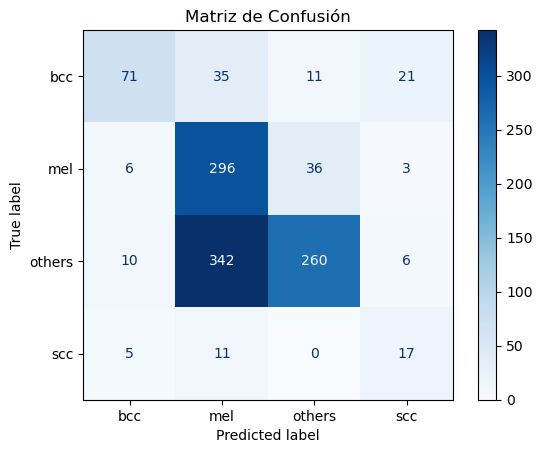

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calcular matriz de confusión
cm = confusion_matrix(labels, predicted_classes)

# Mostrar la matriz de confusión
labels_names = ds['train'].features['label'].names  # Nombres de las clases
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(cmap=plt.cm.Blues)

plt.title("Matriz de Confusión")
plt.show()